In [1]:
"""Importing Libraries"""
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
"""Importing Training And Testing CSV Data From Titanic Dataset"""
data_train = pd.read_csv("training_titanic_x_y_train.csv", delimiter = ",") # Training Data
data_test = pd.read_csv("test_titanic_x_test.csv", delimiter = ",") # Testing data

In [3]:
data_train.head(n=5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,2,"Weisz, Mrs. Leopold (Mathilde Francoise Pede)",female,29.0,1,0,228414,26.000,NaN,S,1
1,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.050,NaN,S,0
2,2,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.000,NaN,S,0
3,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S,0
4,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.050,NaN,S,0


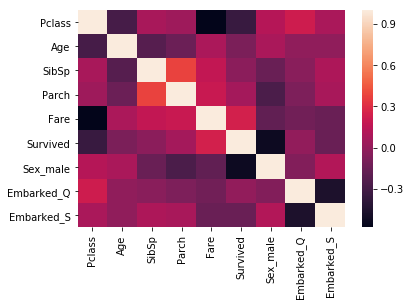

In [26]:
"""Removing non useful columns from training dataset"""
data_train = data_train.loc[:, data_train.columns != 'Name']
data_train = data_train.loc[:, data_train.columns != 'Cabin']
data_train = data_train.loc[:, data_train.columns != 'Ticket']
"""Creating dummies from Sex And Embarked Column"""
data_train = pd.get_dummies(data_train, columns = ['Sex', 'Embarked'], drop_first = True)
"""Filling Age Column Null Values With Mean"""
data_train['Age'] = data_train['Age'].fillna(data_train['Age'].mean())
plt.figure()
sns.heatmap(data_train.corr())


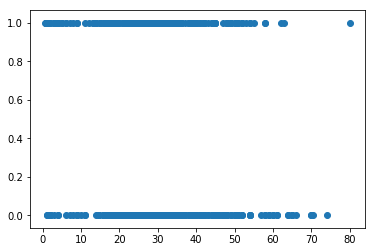

In [27]:
plt.scatter(data_train['Age'], data_train['Survived'])
plt.show()

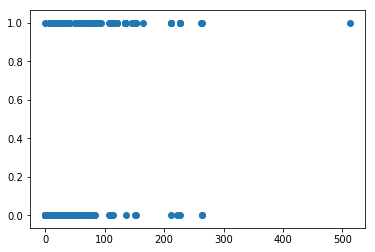

In [28]:
plt.scatter(data_train['Fare'], data_train['Survived'])
plt.show()

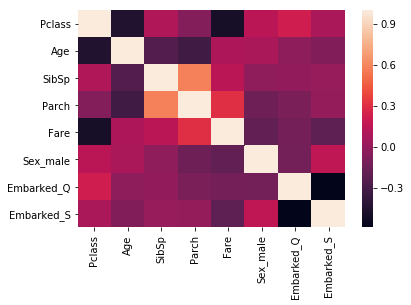

In [29]:
"""Removing non useful columns from testing dataset"""
data_test = data_test.loc[:, data_test.columns != 'Name']
data_test = data_test.loc[:, data_test.columns != 'Cabin']
data_test = data_test.loc[:, data_test.columns != 'Ticket']
"""Creating dummies from Sex And Embarked Column"""
data_test = pd.get_dummies(data_test, columns = ['Sex', 'Embarked'], drop_first = True)
"""Filling Age Column Null Values With Mean"""
data_test['Age'] = data_test['Age'].fillna(data_test['Age'].mean())
plt.figure()
sns.heatmap(data_test.corr())


In [30]:
 """Function To Get Unique values from all the rows and a particular column and returns a SET"""
def get_unique_values(rows, col):
    return set([row[col] for row in rows])

In [31]:
"""Function To Check If the Value is Numeric i.e. Either Integer Or Float"""
def is_value_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

In [32]:
"""Function To generate a Dictionary from all the rows of a Dataframe(input as a 2D list)
The Dictionary Contains All the Unique Predictions Values with the count of their occurence
"""
def unique_count(df):
    counts = {}
    for row in df:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts


In [33]:
""" Class Feature Denotes The Column And Value Which Is Considered As A Feature 
The Class Stores The Column Number And A Value From That Column. 
"""
class feature():
    """Constructor"""
    def __init__(self, column, value):
        self.column = column
        self.value = value
        
    """Function To Compare A Given Data With A Particular Feature Weather It Statisfies The Feature Or Not"""
    def match(self, example):
        val = example[self.column]
        if is_value_numeric(val):
            return val >= self.value
        else:
            return val == self.value
        
    """Helper Function To Print The Feature In Particular Format"""
    def __repr__(self):
        condition = '=='
        if is_value_numeric(self.value):
            condition = '>='
        return "Splitting on feature %s %s %s"%(list(data_train)[self.column], condition, str(self.value))

In [34]:
"""The Following Function Partitions The Dataset On The Basis Of Whether The Values In 
That Row Matches The Feature. If Yes Then Add It To true_rows List Else Add It to false_rows list
"""
def partition_dataset(rows, feature):
    true_rows, false_rows = [], []
    for row in rows:
        if feature.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [35]:
""" Function Calculate The Entropy"""
def entropy(rows):
    results = unique_count(rows) # Calculating Unique Survived And Dead Counter
    e = 0.0
    for r in results:
        p = float(results[r])/len(rows)
        e -= p*math.log2(p)
    return e

In [36]:
""" Function Calculates The Information Gain"""
def information_gain(left, right, current_uncertainity):
    p = float(len(left))/(len(left)+len(right))
    return current_uncertainity - p*entropy(left) - (1-p)*entropy(right)

In [37]:
"""Function Calculates The Splitinfo"""
def splitinfo(left, right):
    result = 0
    valLeft = float(len(left)/(len(left)+len(right)))
    valRight = float(len(right)/(len(left)+len(right)))
    result -= valLeft*math.log2(valLeft)
    result -= valRight*math.log2(valRight)
    return result

In [38]:
"""Find the best question to ask by iterating over every feature / value
and calculating the information gain.
"""
def find_best_feature_to_split(rows):
    best_gain = 0
    best_feature = None
    current_uncertainity = entropy(rows)
    split = 1
    n_features = len(rows[0]) - 1 # Number Of columns
    for col in range(n_features): # Loop On All The Columns
        values = get_unique_values(rows, col) # Get Unique Values Of The Column
        for val in values:
            fr = feature(col, val)
            true_rows, false_rows = partition_dataset(rows, fr) # Partition The Dataset
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue
            gain = information_gain(true_rows, false_rows, current_uncertainity) 
            if gain >= best_gain: # Check for higher value of gain
                best_gain, best_feature = gain, fr
                split = splitinfo(true_rows, false_rows) # calculate split info for the new gain
    return best_gain, best_feature, best_gain/split

In [39]:
"""The Following Class Denotes the non leaf nodes of the tree. It Contains reference to the left
and right child and the feature on which it splits and also the gain ratio.It also contains
a dictionary that contains the number of times a value has appeared."""
class decision_node():
    def __init__(self, feature, true_feature, false_feature, count, gain_ratio):
        self.feature = feature
        self.true_feature = true_feature
        self.false_feature = false_feature
        self.gain_ratio = gain_ratio
        self.count = count
        self.entropy = 0
        total = 0
        for i, j in self.count.items():
            total += j
        for i, j in self.count.items():
            self.entropy -= float(j/total)*math.log2(float(j/total))

In [40]:
"""The following class denotes the leaf node of the tree. It Also contains a 
dictionary that contains the number of times a value has appeared."""
class leaf():
    def __init__(self, rows):
        self.predictions = unique_count(rows)
        self.count = {}
        counts = {}
        for i,j in self.predictions.items():
            if i not in counts:
                counts[i] = 0
            counts[i] += j
        self.count = counts

In [41]:
"""Function To Build the tree recursively"""
def build_tree(rows):
    gain, fr, gain_ratio = find_best_feature_to_split(rows)
    if gain == 0: # Base Case
        leafNode = leaf(rows)
        return leafNode
    true_rows, false_rows = partition_dataset(rows, fr) # Partition Dataset For Current Feature
    true_branch = build_tree(true_rows) # recurive calls
    false_branch = build_tree(false_rows) # recursive calls
    finalCount = {} # Count of the predicted values from left and right branch
    for i, j in true_branch.count.items():
        if i not in finalCount:
            finalCount[i] = 0
        finalCount[i] += j
    for i, j in false_branch.count.items():
        if i not in finalCount:
            finalCount[i] = 0
        finalCount[i] += j
    return decision_node(fr, true_branch, false_branch, finalCount, gain_ratio)

In [42]:
"""Function to print the tree in level order manner"""
def level_order(root):
    if root is None:
        return
    queue = [] # queue to maintain level order
    queue.append(root) # Enqueue Root
    level = 0 # count on which level the node is
    while(True):
        nodeCount = len(queue)
        if nodeCount == 0:
            break
        while(nodeCount > 0): # Dequeue all nodes Of Current Level And Enqueue All nodes of Next level
            node = queue[0]
            print("Level %d"%(level))
            if not isinstance(node, leaf): # If not a leaf node
                print("Count of Survived = %d"%(node.count[1]))
                print("Count of Not Survived = %d"%(node.count[0]))
                print(node.feature, "with gain ratio %f"%(node.gain_ratio))
                print("Current Entropy is %f"%(node.entropy))
                if node.true_feature != None:
                    queue.append(node.true_feature)
                if node.false_feature != None:
                    queue.append(node.false_feature)
            else: # if a leaf node
                if 1 in node.predictions:
                    print("Count of Survived = %d"%(node.predictions[1]))
                if 0 in node.predictions:
                    print("Count of Not Survived = %d"%(node.predictions[0]))
                print("Current Entropy Is 0.0")
                print("Reached Leaf Node")
                pass
            queue.pop(0)
            nodeCount -= 1
            print("\n")
        level+=1
    return

In [44]:
tree = build_tree(data_train.values.tolist()) #convert pd dataframe to list and passing to build tree
level_order(tree) # calling level order of tree

Level 0
Count of Survived = 484
Count of Not Survived = 184
Splitting on feature Embarked_Q >= 1.0 with gain ratio 0.394257
Current Entropy is 0.849176


Level 1
Count of Not Survived = 50
Current Entropy Is 0.0
Reached Leaf Node


Level 1
Count of Survived = 484
Count of Not Survived = 134
Splitting on feature Pclass >= 2.0 with gain ratio 0.067117
Current Entropy is 0.754334


Level 2
Count of Survived = 391
Count of Not Survived = 67
Splitting on feature Fare >= 7.25 with gain ratio 0.120061
Current Entropy is 0.600473


Level 2
Count of Survived = 93
Count of Not Survived = 67
Splitting on feature Fare >= 27.7208 with gain ratio 0.148743
Current Entropy is 0.980867


Level 3
Count of Survived = 367
Count of Not Survived = 44
Splitting on feature Fare >= 13.4167 with gain ratio 0.029699
Current Entropy is 0.490971


Level 3
Count of Survived = 24
Count of Not Survived = 23
Splitting on feature Fare >= 7.225 with gain ratio 0.789700
Current Entropy is 0.999673


Level 3
Count of Surv

In [45]:
"""Predict Helper Funcion"""
def predictHelper(row, node):
    if isinstance(node, leaf):
        return node.predictions
    if node.feature.match(row):
        return predictHelper(row, node.true_feature)
    else:
        return predictHelper(row, node.false_feature)

In [46]:
"""Function To predict on the test values"""
def predict(row):
    counts = predictHelper(row, tree)
    total = sum(counts.values()) * 1.0
    probability = {}
    for label in counts.keys():
        probability[label] = str(int(counts[label])/total * 100) + '%'
    return probability

In [47]:
arr = data_test.values.tolist()
for a in arr:
    p = (predict(a))
    if 0 in p:
        print("Dead")
    else:
        print("Survived")

Dead
Dead
Survived
Dead
Dead
Survived
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Survived
Dead
Survived
Survived
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Survived
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Survived
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Survived
Dead
Dead
Dead
Dea